In [1]:
import warnings
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import seaborn as sns

import ipywidgets
from ipywidgets import interact
import IPython
# If in your browser the figures are not nicely vizualized, change the following line.
rcParams['font.size'] = 12

warnings.filterwarnings('ignore')

layout = ipywidgets.Layout(width='auto', height='40px')


## Bayesian Linear Regression:

Consider a data generating process given by the following probabilistic model, $y |w, x \sim \mathcal{N}(w^\top x, \sigma_n^2)$. The objective is to find the posterior distribution of $p(w|X,Y)$. 

Using Bayes' Rule, $ p(w|X,y) = \frac{p(y|w,X) p(w|X) }{p(y|X)}$, where $p(y|w,X)$ is the likelihood, $p(w|X)$ is the prior, and $p(y|X)$ is a normalization factor. 

In our case, $p(y|w,X) = \mathcal{N}(w^\top x, \sigma_n^2)$. Compared to ordinary linear regression, with Bayesian Regression we have the freedom to place a prior $p(w|X)$. In this example, we will use a gaussian prior on $w$ given by $p(w|X) = \mathcal{N}(0, \Sigma_p^2)$. In this particular case, we have a closed form of the posterior, that is given by: $$p(y|w,X) = \mathcal{N}(\sigma_n^{-2} A^{-1} X^\top y, A^{-1}),$$
where $A = \sigma_n^{-2} X^\top  X+ \Sigma_p^{-1}$. 


### Maximum Likelihood estimator: 
The maximum likelihood estimator is a point estimate $\hat{w}_\text{MLE}$ that maximizes the likelihood of the observations, i.e., $\hat{w}_\text{MLE} = \arg \max p(y|w, X)$. For this particular model, this is given by $\hat{w}_\text{MLE} = (X^\top  X)^{-1} X^\top y$. This coincides with the Ordinary Least Squares solution.


### Maximum a Posteriori estimator: 
The maximum-a-posteriori estimator, instead, maximizes the posterior probability, i.e.,  $\hat{w}_\text{MAP} = \arg \max p(w|y, X) = \arg \max p(y|w, X) p(w|X)$. For this particular model, this is given by $\hat{w}_\text{MAP} = (X^\top  X + \sigma_n^2 \Sigma_p^{-1})^{-1} X^\top y$, i.e. Ridge Linear Regression with regularization $\lambda = \sigma_n^2 \Sigma_p^{-1}$. 

### Predictive Distribution:
The predictive distribution at test locations $X_\star$ is $p(y_\star|X_\star, X, y) = \mathcal{N}(\sigma_n^{-2} X_\star A^{-1} X^\top y, X_\star A^{-1} X_\star^\top) $

In [2]:
rcParams['figure.figsize'] = (20, 12)
rcParams['font.size'] = 16
rcParams['lines.linewidth'] = 4
rcParams['lines.markersize'] = 20
colors = sns.color_palette()
true_c, mle_c, map_c = colors[0], colors[2], colors[3]
prior_color, posterior_color = colors[5], colors[6]
epistemic_color, aleatoric_color = colors[1], colors[4]
x0_c = colors[7]

w = np.random.multivariate_normal(np.zeros(2), np.array([[1., 0], [0, 1.]])) # 0.5

def blr(num_points, noise, x0):
    num_test_points = 1000
    X = np.stack((np.ones(num_points), np.random.rand(num_points))).T
    X_plot = np.stack(
        (np.ones(num_test_points), np.linspace(-0.5, 1.5, num_test_points))).T
    sigma_p = np.array([[1., 0], [0, 1.]])  # Covariance matrix of posterior.

    # Sample a parameter from the prior.
    def get_w():
        return np.random.multivariate_normal(
            np.zeros(2), np.array([[0.5, 0], [0, 1.]]))
    def sample_w():
        global w
        w = get_w()
        sample()

    def sample():
        y = X @ w + noise * np.random.randn(num_points)

        # Calculate the posterior mean and covariance
        A = 1 / (noise ** 2) * X.T @ X + np.linalg.pinv(sigma_p) # numerical problem when noise = 0 
        
        A_inv = np.linalg.pinv(A)
        mu_posterior = 1 / (noise ** 2) * A_inv @ X.T @ y
        cov_posterior = A_inv

        # MLE solution.
        w_MLE = np.linalg.pinv(X.T @ X) @ X.T @ y
        y_MLE = X_plot @ w_MLE

        # MAP Solution.
        w_MAP = mu_posterior
        y_MAP = X_plot @ w_MAP

        # Predictive mean and variance
        mu_pred = X_plot @ mu_posterior
        std_dev = np.diagonal(X_plot @ A_inv @ X_plot.T) ** 0.5

        fig, axes = plt.subplots(2, 2)

        # Predictions.
        axes[0, 0].plot(X[:, 1], y, '*', color=true_c, label="True Data")
        axes[0, 0].plot(X_plot[:, 1], y_MLE, '--', color=mle_c, label='MLE')
        axes[0, 0].plot(X_plot[:, 1], y_MAP, '--', color=map_c, label='MAP')
        axes[0, 0].plot(X_plot[:, 1], X_plot @ w, '--', color=true_c, label='True')

        axes[0, 0].fill_between(X_plot[:, 1], mu_pred - 3 * std_dev, mu_pred +
                                3 * std_dev, color=epistemic_color, alpha=0.5, label='Epistemic Uncertainty')
        axes[0, 0].fill_between(X_plot[:, 1], mu_pred - 3 * std_dev, mu_pred - 3 * std_dev - 3 * noise, 
                                color=aleatoric_color, alpha=0.5, label='Aleatoric Uncertainty')
        axes[0, 0].fill_between(X_plot[:, 1], mu_pred + 3 * std_dev, mu_pred + 3 * std_dev + 3 * noise, 
                                color=aleatoric_color, alpha=0.5)
        
        ### add vertical line
        axes[0,0].vlines(x0, -10,10,color = x0_c, linestyle = 'dotted', label = 'Test Point x')

        w_sample = np.random.multivariate_normal(mu_posterior, cov_posterior)
        axes[0, 0].plot(X_plot[:, 1], X_plot @ w_sample, '-.', color=posterior_color, alpha=0.5, label='Posterior Samples')
        for k in range(3):
            w_sample = np.random.multivariate_normal(mu_posterior, cov_posterior)
            axes[0, 0].plot(X_plot[:, 1], X_plot @ w_sample, '-.', alpha=0.5, color=posterior_color)

        axes[0, 0].legend(loc='lower left', ncol=2)
        axes[0, 0].set_xlabel('X')
        axes[0, 0].set_ylabel('y')
        axes[0, 0].set_title('Predictions')

        # Posterior distribution at X = 1
        x_star = np.array([1., x0])

        y_mle = x_star @ w_MLE
        y_map = x_star @ w_MAP

        mu = x_star @ mu_posterior
        sigma = (x_star @ A_inv @ x_star.T) ** 0.5
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        axes[0, 1].plot(x, stats.norm.pdf(x, mu, sigma),
                        color=map_c, label='Predictive Distribution')
        axes[0, 1].vlines(y_mle, 0, 5, color=mle_c, linestyle='dashed', label='MLE')
        axes[0, 1].vlines(y_map, 0, 5, color=map_c, linestyle='dashed', label='MAP')
        axes[0, 1].vlines(x_star @ w, 0, 5, color=true_c, linestyle='dashed', label='True')
        axes[0, 1].legend(loc='upper left')
        axes[0, 1].set_title(f'Predictive distribtuion at X={x0}')

        # Posterior distribution of w_0
        mu = mu_posterior[0]
        sigma = cov_posterior[0, 0] ** 0.5

        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        axes[1, 0].plot(x, stats.norm.pdf(x, mu, sigma), color=map_c, label='Posterior')

        x = np.linspace(- 3 * sigma_p[0, 0], 3 * sigma_p[0, 0], 100)
        axes[1, 0].plot(x, stats.norm.pdf(x, np.zeros(
            100), sigma_p[0, 0]), color=prior_color, label='Prior')

        axes[1, 0].vlines(w_MLE[0], 0, 5, color=mle_c, linestyle='dashed', label='MLE')
        axes[1, 0].vlines(w_MAP[0], 0, 5, color=map_c, linestyle='dashed', label='MAP')
        axes[1, 0].vlines(w[0], 0, 5, color=true_c, linestyle='dashed', label='True')

        axes[1, 0].legend(loc='upper left')
        axes[1, 0].set_title('Posterior Distribution of Bias')

        # Posterior distribution of w_1
        mu = mu_posterior[1]
        sigma = cov_posterior[1, 1] ** 0.5

        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        axes[1, 1].plot(x, stats.norm.pdf(x, mu, sigma),
                        color=map_c, label='Posterior')

        x = np.linspace(- 3 * sigma_p[1, 1], 3 * sigma_p[1, 1], 100)
        axes[1, 1].plot(x, stats.norm.pdf(x, np.zeros(
            100), sigma_p[1, 1]), color=prior_color, label='Prior')

        axes[1, 1].vlines(w_MLE[1], 0, 5, color=mle_c, linestyle='dashed', label='MLE')
        axes[1, 1].vlines(w_MAP[1], 0, 5, color=map_c, linestyle='dashed', label='MAP')
        axes[1, 1].vlines(w[1], 0, 5, color=true_c, linestyle='dashed', label='True')
        axes[1, 1].set_title('Posterior Distribution of Weight')

        axes[0, 0].set_xlim([-0.5, 1.5])
        axes[0, 0].set_ylim([-5, 5])

        axes[0, 1].set_xlim([-3, 3])
        axes[0, 1].set_ylim([0, 3])
        
        axes[1, 0].set_xlim([-3, 3])
        axes[1, 0].set_ylim([0, 2])
        
        axes[1, 1].set_xlim([-3, 3])
        axes[1, 1].set_ylim([0, 2])
        
        plt.tight_layout(pad=0.2)
        IPython.display.clear_output(wait=True)
        IPython.display.display(plt.gcf())
        plt.close()

        button = ipywidgets.Button(
            description="Re-Sample y (from likelihood)", layout=layout)
        button.on_click(lambda b: sample())
        display(button)
        button_w = ipywidgets.Button(
            description="Re-Sample w (from prior)", layout=layout)
        button_w.on_click(lambda b: sample_w())
        display(button_w)
    sample()

interact(blr,
         num_points=ipywidgets.IntSlider(
             value=5,
             min=2,
             max=200,
             description='Number of Data Points:',
             style={'description_width': 'initial'},
             continuous_update=False
         ),
         noise=ipywidgets.FloatSlider(
             value=0.5,
             min=1e-6,
             max=20,
             step=0.1,
             description='Likelihood ' + chr(963) +'_n:',
             style={'description_width': 'initial'},
             continuous_update=False),
         x0=ipywidgets.FloatSlider(
             value=0.5,
             min=-0.5,
             max=1.5,
             step=0.1,
             description='Test point:',
             style={'description_width': 'initial'},
             continuous_update=False)
         );

interactive(children=(IntSlider(value=5, continuous_update=False, description='Number of Data Points:', max=20…

## Demo Guide:
#### some explanation
- number of data points: uniform sample points in range(0,1) and generate noisy data based on given likelihood noise $\sigma_n$
- likelihood $\sigma_n$: the standard deviation of independant Gaussian noise. (If this is equal to 0, there will be a case of division by 0)
- the prior distribution of weight and bias is standard normal distribution
- Test point: $x_*$ for prediction
- Re-sample y (from likelihood): regenerate data points by sampling from noise given variance, $\sigma_n$
- Re-sample w (from prior): regenerate data points by sampling weight and resample y

#### play around
- See how the uncertainty changes when changing number of data points
- See how the uncertainty changes when changing the likelihood noise variance
- See how the predictive distribution changes when test point far away from data points

# Bayesian Linear Regression on Real Data: Predict the Bike demand in Winter Working Sunny Days

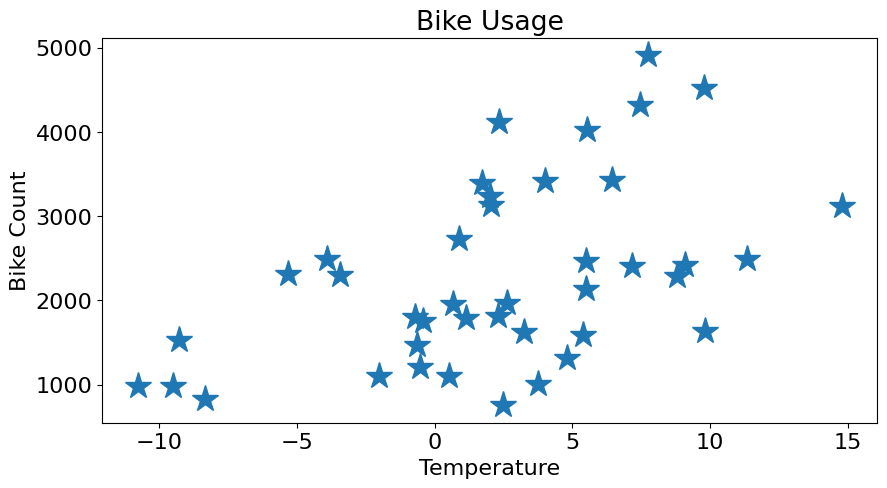

In [3]:
rcParams['figure.figsize'] = (10, 5)
df = pd.read_csv("../data/bike-sharing.csv")
Tmin, Tmax =-16, +50 
df_filtered = df[(df.season == 1)  & (df.workingday == 0)  & (df.weathersit == 1)]

# y = df_filtered["count"].values
y = df_filtered["cnt"].values # Normalize
mean, std = np.mean(y), np.std(y)
y = (y - np.mean(y)) / std
X_ = df_filtered[["atemp"]].values

plt.plot(Tmin + (Tmax - Tmin) * X_, std * y + mean, '*');
plt.xlabel('Temperature')
plt.ylabel('Bike Count')
plt.title("Bike Usage")
plt.show();

In [4]:
rcParams['figure.figsize'] = (20, 8)
rcParams['font.size'] = 16
rcParams['lines.linewidth'] = 5
rcParams['lines.markersize'] = 16

def bike_prediction(noise, prior):
    N = len(y)
    X_plot = np.atleast_2d(np.linspace(0, 1.1 * np.max(X_), 100)).T

    X = np.concatenate((np.ones((N, 1)), X_), axis=1)  # Attach a bias.
    X_plot = np.concatenate((np.ones((100, 1)), X_plot), axis=1)  # Attach a bias.
    sigma_p = prior * np.eye(2)

    # # Calculate the posterior mean and covariance

    A = 1 / (noise ** 2) * X.T @ X + np.linalg.inv(sigma_p) 
    A_inv = np.linalg.inv(A)
    mu_posterior = 1 / (noise ** 2) * A_inv @ X.T @ y 
    cov_posterior = A_inv

    # # MLE solution.
    w_MLE = np.linalg.inv(X.T @ X) @ X.T @ y
    y_MLE = X_plot @ w_MLE

    # # MAP Solution.
    w_MAP = mu_posterior 
    y_MAP = X_plot @ w_MAP

    # Predictive mean and variance
    mu_pred = X_plot @ mu_posterior
    std_dev = np.diagonal(X_plot @ A_inv @ X_plot.T) ** 0.5
    
    # Estimate aleatoric uncertainty:

    plt.plot(Tmin + (Tmax - Tmin) * X[:, 1], mean + std * y, 'b*', label='train data')
    plt.plot(Tmin + (Tmax - Tmin) * X_plot[:, 1], mean + std * y_MLE, 'r--', label='MLE')
    plt.plot(Tmin + (Tmax - Tmin) * X_plot[:, 1], mean + std * y_MAP, 'g--', label='MAP')
    plt.fill_between(
        Tmin + (Tmax - Tmin) * X_plot[:, 1], 
        mean + std * (mu_pred - 3 * std_dev), 
        mean + std * (mu_pred + 3 * std_dev), 
        color=epistemic_color, 
        alpha=0.5, 
        label='Epistemic Uncertainty'
    )
    
    plt.fill_between(
        Tmin + (Tmax - Tmin) * X_plot[:, 1], 
        mean + std * (mu_pred - 3 * std_dev - 3 * noise), 
        mean + std * (mu_pred - 3 * std_dev), 
        color=aleatoric_color, 
        alpha=0.5, 
        label='Epistemic Uncertainty'
    )
    
    plt.fill_between(
        Tmin + (Tmax - Tmin) * X_plot[:, 1], 
        mean + std * (mu_pred + 3 * std_dev + 3 * noise), 
        mean + std * (mu_pred + 3 * std_dev), 
        color=aleatoric_color, 
        alpha=0.5, 
    )
    
    plt.legend(loc='upper left')
    plt.title("Predictive Distribution")
    plt.xlabel('Temperature')
    plt.ylabel('Bike Count')
    plt.show();

interact(
    bike_prediction, 
    noise=ipywidgets.FloatLogSlider(
        value=1, min=-2, max=1, continuous_update=False, description="Likelihood std dev "+  chr(963) +'_n:', style = {'description_width': 'initial'}),
    prior=ipywidgets.FloatLogSlider(value=1e1, min=-2, max=3, continuous_update=False, description="Prior Variance", style = {'description_width': 'initial'}),
);


interactive(children=(FloatLogSlider(value=1.0, continuous_update=False, description='Likelihood std dev σ_n:'…

## Demo Guide:
#### some explanation
Unlike the above demo, this demo use BLR given data from real world (The hidden model is not necessarily linear model) 
- Likelihood std dev $\sigma_n$: The standard deviation of independant Gaussian noise
- Prior Variance: Assume the prior distribution of multivariate normal distribution with diagonal variance which are equal.

#### play around
- See how the uncertainty changes when changing likelihood std dev
- See how the uncertainty changes when changing the prior variance